## Prep

In [1]:
# Import packages
import pandas as pd
import plotly.graph_objects as go
import networkx as nx
from ds_common_utils.aux.io.snowflake_tools import SnowflakeTools
from math import log
from networkx.algorithms.community import greedy_modularity_communities
import matplotlib.pyplot as plt
import community.community_louvain as community_louvain
import numpy as np

In [2]:
# Get connection
con = SnowflakeTools().get_snowflake_ctx(
     method = 'token',
    user = '250807',
    role = 'INSIGHT_ANALYST_MERCH_DE_GENERAL_PRD',
    warehouse = 'INSIGHT_ANALYST_WH'
)
with open('sql/item_association.sql', 'r') as query:
        df = pd.read_sql_query(query.read(), con)

snowflake_tools - 2025-06-25 17:44:35.245140+10:00 - Generating new token with 'INSIGHT_ANALYST_MERCH_DE_GENERAL_PRD' role and 'SESSION:ROLE-ANY' scope...
snowflake_tools - 2025-06-25 17:44:43.103561+10:00 - Saved token with '2025-06-25 21:44:43+10:00' expiry...


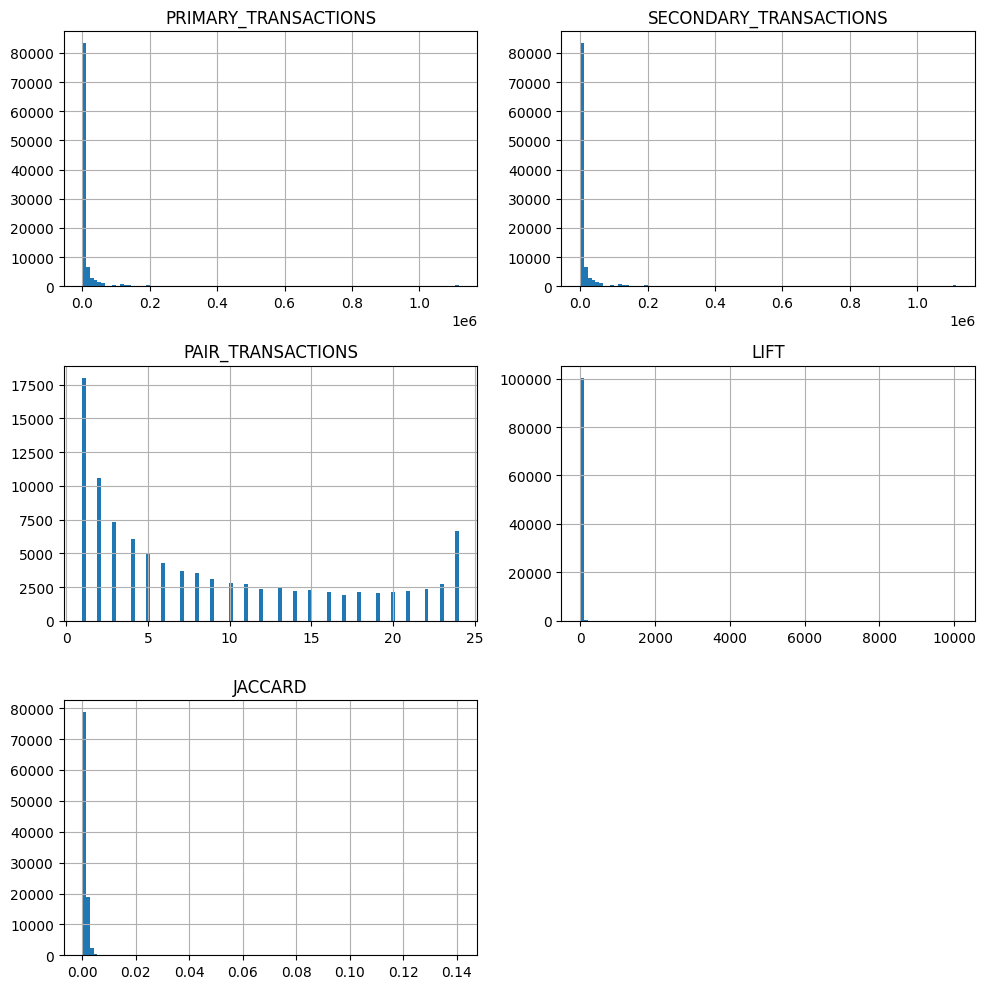

In [3]:
# Plot histograms of numerical columns
numeric_cols = df.select_dtypes(include='number').columns
df[numeric_cols].hist(bins=100, figsize=(10, 10), layout=(3, 2))
plt.tight_layout()
plt.show()

## Parameter Tuning

In [292]:
TRX_THRESHOLD = 20 # Min N frequent pairs
QUANTILE = 0.995 # Nth percentile of metric similarity
TOP_N = 20 # top-N associated item classes per primary class
RESO = 0.5 # >1.0 → more, smaller communities
METRIC = 'LIFT' # LIFT or JACCARD

## Working

In [293]:
filtered_df = df[(df['PRIMARY_ID'] != '400 GROWING MEDIA' ) & ( df['SECONDARY_ID']!='400 GROWING MEDIA')]

filtered_df = filtered_df[filtered_df['PAIR_TRANSACTIONS'] >= TRX_THRESHOLD]
threshold = filtered_df[METRIC].quantile(QUANTILE)
filtered_df = filtered_df[filtered_df[METRIC] >= threshold]
top_edges = filtered_df.sort_values(METRIC, ascending=False).groupby('PRIMARY_ID').head(TOP_N)


In [294]:
filtered_df.sort_values(by='PAIR_TRANSACTIONS', ascending=False)

,PRIMARY_ID,SECONDARY_ID,PRIMARY_TRANSACTIONS,SECONDARY_TRANSACTIONS,TRX_START_MONTH,TRX_END_MONTH,PAIR_TRANSACTIONS,LIFT,JACCARD
98708,403 DRAPERY FITTINGS,403 CURTAINS,2405,576,2024-06-01,2025-05-01,24,19.344785,0.008116
85515,401 TOOLS AND ACCESSORIES,400 GROUT AND SEALER,708,874,2024-06-01,2025-05-01,24,43.306869,0.015404
45846,400 POWER SANDING,400 CORDED AC,2798,1162,2024-06-01,2025-05-01,24,8.242285,0.006098
47264,400 PVC PIPE AND FITTINGS,400 SURFACE WATER DRAINAGE,1978,919,2024-06-01,2025-05-01,24,14.742111,0.008354
53774,400 SURFACE WATER DRAINAGE,400 PVC PIPE AND FITTINGS,949,1978,2024-06-01,2025-05-01,24,14.276080,0.008267
24093,400 GROUT AND SEALER,401 TOOLS AND ACCESSORIES,874,698,2024-06-01,2025-05-01,24,43.927311,0.015504
24049,400 GROUT AND SEALER,401 FLOORING ADHESIVE,874,689,2024-06-01,2025-05-01,24,44.501108,0.015595
20349,400 FUEL CONTAINERS,400 OPE MAINTENANCE,1271,2412,2024-06-01,2025-05-01,24,8.741352,0.006559
69507,401 FLOORING ADHESIVE,400 GROUT AND SEALER,701,874,2024-06-01,2025-05-01,24,43.739320,0.015474
69673,401 FLOORING ADHESIVE,401 TOOLS AND ACCESSORIES,701,698,2024-06-01,2025-05-01,24,54.768145,0.017455


In [295]:
mode='lines',
line_shape='spline'
    
# Build node size map from your DataFrame
node_size_map = dict(zip(top_edges['PRIMARY_ID'], top_edges['PRIMARY_TRANSACTIONS']))

# Convert values to NumPy array
sizes = np.array(list(node_size_map.values()))

# Use np.ptp instead of .ptp()
norm_sizes = (sizes - sizes.min()) / np.ptp(sizes)  # scale to 0–1
scaled_sizes = 10 + norm_sizes * 30                 # scale to 10–40

# Final size map: Product ID → Scaled Size
scaled_size_map = dict(zip(node_size_map.keys(), scaled_sizes))

# Step 1: Build the full graph
G = nx.Graph()
for _, row in top_edges.iterrows():
    G.add_edge(row['PRIMARY_ID'], row['SECONDARY_ID'], weight=row[METRIC])

# Step 2: Louvain community detection
partition = community_louvain.best_partition(G, weight=METRIC, resolution=RESO)

# Step 3: Layout
pos = nx.spring_layout(G, weight='weight', seed=42
                      )

# Step 4: Edge trace (no filter on weight)
edge_x, edge_y = [], []
for u, v in G.edges():
    x0, y0 = pos[u]
    x1, y1 = pos[v]
    edge_x += [x0, x1, None]
    edge_y += [y0, y1, None]

edge_trace = go.Scatter(
    x=edge_x,
    y=edge_y,
    line=dict(width=1, color='gray'),
    hoverinfo='none',
    mode='lines'
)

# Step 5: Node trace with Louvain cluster coloring
color_list = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728',
              '#9467bd', '#8c564b', '#e377c2', '#7f7f7f',
              '#bcbd22', '#17becf']  # Extend if you expect >10 clusters

node_x, node_y, node_color, node_size, hover_text = [], [], [], [], []

for node in G.nodes():
    x, y = pos[node]
    cluster = partition[node]
    size = scaled_size_map.get(node, 10)  # default to small if missing

    node_x.append(x)
    node_y.append(y)
    node_color.append(color_list[cluster % len(color_list)])
    node_size.append(size)
    hover_text.append(f"Product ID: {node}<br>Cluster: {cluster}<br>Transactions: {int(size)}")

node_trace = go.Scatter(
    x=node_x,
    y=node_y,
    mode='markers+text',
    hoverinfo='text',
    text=[str(node) for node in G.nodes()],
    textposition='top center',
    marker=dict(
        color=node_color,
        size=node_size,  # <--- size now dynamic!
        line=dict(width=2, color='black')
    ),
    textfont=dict(
    size=16,          # increase for visibility
    color='black',
    family='Arial'
)
)
# Step 6: Plot
fig = go.Figure(
    data=[edge_trace, node_trace],
    layout=go.Layout(
        width=1200,          # increase width
    height=800, 
        title=dict(text='Louvain Product Clustering (All Edges)', x=0.5, font=dict(size=16)),
        showlegend=False,
        hovermode='closest',
        margin=dict(b=20, l=20, r=20, t=40),
        xaxis=dict(showgrid=False, zeroline=False, showticklabels=False),
        yaxis=dict(showgrid=False, zeroline=False, showticklabels=False)
    )
)

## Results

In [296]:
fig.show()

In [299]:
# Merge community partition info with filtered edges
partition_df = pd.DataFrame.from_dict(partition, orient='index', columns=['segment']).reset_index()
partition_df.rename(columns={'index': 'PRIMARY_ID'}, inplace=True)

# Merge and deduplicate
labelled_df = filtered_df.merge(partition_df, on='PRIMARY_ID', how='left')
labelled_df = labelled_df[['PRIMARY_ID', 'SECONDARY_ID', 'PRIMARY_TRANSACTIONS', 'SECONDARY_TRANSACTIONS', 'PAIR_TRANSACTIONS', METRIC, 'segment']].drop_duplicates()
labelled_df = labelled_df.sort_values(by=['segment', METRIC]).reset_index(drop=True)

# Expand display limits
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)

In [310]:
display(labelled_df)

## Regroup segments

In [318]:
macro_mapping = {
    0:  'Noise & Impulse',
    1:  'Surface Prep & Sealants',
    4:  'Display & Décor',
    5:  'Installation & Tools',
    6:  'Installation & Tools',
    7:  'Display & Décor',
    8:  'Irrigation & Drainage',
    9:  'Installation & Tools',
    13: 'Irrigation & Drainage',
    14: 'Installation & Tools',
    15: 'Irrigation & Drainage',
    16: 'Installation & Tools',
    17: 'Irrigation & Drainage'
}

# Relabel and aggregate
labelled_df['Macro-segment'] = labelled_df['segment'].map(macro_mapping)

In [322]:
labelled_df.groupby(['Macro-segment'], as_index=False).agg(total_PRIMARY_TRANSACTIONS=('PRIMARY_TRANSACTIONS', 'sum')).sort_values('total_PRIMARY_TRANSACTIONS')

,Macro-segment,total_PRIMARY_TRANSACTIONS
3,Noise & Impulse,297
0,Display & Décor,4421
4,Surface Prep & Sealants,9849
2,Irrigation & Drainage,28028
1,Installation & Tools,71718


In [320]:
labelled_df.groupby(['Macro-segment', 'PRIMARY_ID'], as_index=False).agg(total_PRIMARY_TRANSACTIONS=('PRIMARY_TRANSACTIONS', 'sum')).sort_values(['Macro-segment', 'total_PRIMARY_TRANSACTIONS'])

,Macro-segment,PRIMARY_ID,total_PRIMARY_TRANSACTIONS
0,Display & Décor,400 FURNITURE LEGS,566
2,Display & Décor,403 CURTAINS,582
1,Display & Décor,400 PANELS,868
3,Display & Décor,403 DRAPERY FITTINGS,2405
4,Installation & Tools,400 ADDITIVES,185
21,Installation & Tools,400 STRUCTURAL OTHER,218
23,Installation & Tools,402 TOOL BAGS AND BELTS,374
12,Installation & Tools,400 INSULATION,400
22,Installation & Tools,401 STEEL REINFORCING,436
18,Installation & Tools,400 RIVETS,469


**Display & Décor** 

(Panels, Furniture Legs, Curtains, Drapery Fittings)
– Projects installing living-wall displays or decorative planter stands in retail/hospitality showrooms.

**Installation & Tools** 

(Drilling, Fasteners, Masonry Tools, Sanders, Batteries, Dry Mix, etc.)
– On-site trade kits for framing, assembly and finishing when building or servicing planter beds.

**Irrigation & Drainage** 

(Pumps, Pipes & Fittings, Guttering, Framing Timber, Plywood)
– Water-management under new media: drainage lines, downpipes, pump installs plus structural bed framing.

**Surface Prep & Sealants** 

(Grout & Sealer, Adhesives, Flooring Trim, Tiles, Tiling Tools)
– Waterproofing and finishing planter surrounds in tiled or concrete settings.

**Noise & Impulse** - EXCLUDE THIS

(Hot Drinks, Cold Food & Sweets)
– Café sales unrelated to soil projects.

#